# Code for the habr.com article

In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from sklearn.metrics import mean_absolute_error
import lmfit
from tqdm.auto import tqdm
import pickle
import joblib
import matplotlib.dates as mdates

In [6]:
sns.set()
%matplotlib inline

In [7]:
%load_ext autoreload

In [8]:
%autoreload 2

In [9]:
sns.set_context("talk")
sns.set_style("ticks")

# Load data

In [10]:
df = pd.read_csv('data/data.csv', sep=';')
df.head()

,Дата,Регион,Заражений,Выздоровлений,Смертей,Смертей за день,Заражений за день,Выздоровлений за день
0,01.03.2021,Алтайский край,43666,38979,1511,9,133,94
1,27.12.2020,Еврейская АО,3680,2662,68,1,16,33
2,23.09.2020,Брянская обл.,9117,7387,37,0,39,34
3,26.09.2020,Костромская обл.,4553,3329,67,5,54,44
4,25.10.2020,Нижегородская обл.,39260,33221,711,11,396,224


In [11]:
df.columns = ['date', 'region', 'total_infected', 'total_recovered', 'total_dead', 'deaths_per_day', 'infected_per_day', 'recovered_per_day']
df = df[df.region == 'Москва'].reset_index()
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
df = df.drop(columns=['index', 'region'])
df = df.sort_values(by='date')
df.head()

,date,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day
318,2020-03-12,21,0,0,0,21,0
175,2020-03-13,26,0,0,0,5,0
33,2020-03-14,35,0,0,0,9,0
168,2020-03-15,35,1,0,0,0,1
26,2020-03-16,53,1,0,0,18,0


In [12]:
assert (pd.date_range(start=df.date.iloc[0], end=df.date.iloc[-1], freq='D') == df.date).all()

In [13]:
df.index = pd.date_range(start=df.date.iloc[0], end=df.date.iloc[-1], freq='D')
df.index 

DatetimeIndex(['2020-03-12', '2020-03-13', '2020-03-14', '2020-03-15',
               '2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19',
               '2020-03-20', '2020-03-21',
               ...
               '2021-03-14', '2021-03-15', '2021-03-16', '2021-03-17',
               '2021-03-18', '2021-03-19', '2021-03-20', '2021-03-21',
               '2021-03-22', '2021-03-23'],
              dtype='datetime64[ns]', length=377, freq='D')

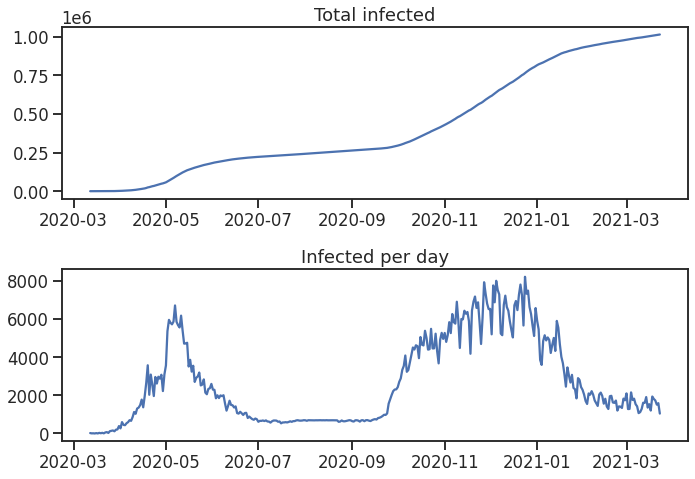

In [14]:
fig = plt.figure(figsize=(10,7))
ax1 = plt.subplot(2, 1, 1)
# df.total_infected.plot()
plt.plot(df.index, df.total_infected.values)
plt.title("Total infected")
plt.subplot(2, 1, 2, sharex=ax1)
plt.plot(df.index, df.infected_per_day.values)
plt.title("Infected per day")
plt.tight_layout()
plt.savefig('figures/habr/infected_overview.png')
plt.show()

In [15]:
df_smoothed = df.rolling(7).mean().round(5)
df_smoothed.columns = [col + '_ma7' for col in df_smoothed.columns]

full_df = pd.concat([df, df_smoothed], axis=1)

for column in full_df.columns:
    if column.endswith('_ma7'):
        original_column = column.strip('_ma7')
        full_df[column] = full_df[column].fillna(full_df[original_column])

In [16]:
df = full_df

In [17]:
from IPython.display import display, HTML

display(df)
# display(HTML(df.to_html()))

,date,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,total_infected_ma7,total_recovered_ma7,total_dead_ma7,deaths_per_day_ma7,infected_per_day_ma7,recovered_per_day_ma7
2020-03-12,2020-03-12,21,0,0,0,21,0,2.100000e+01,0.00000,0.00000,0.00000,21.00000,0.00000
2020-03-13,2020-03-13,26,0,0,0,5,0,2.600000e+01,0.00000,0.00000,0.00000,5.00000,0.00000
2020-03-14,2020-03-14,35,0,0,0,9,0,3.500000e+01,0.00000,0.00000,0.00000,9.00000,0.00000
2020-03-15,2020-03-15,35,1,0,0,0,1,3.500000e+01,1.00000,0.00000,0.00000,0.00000,1.00000
2020-03-16,2020-03-16,53,1,0,0,18,0,5.300000e+01,1.00000,0.00000,0.00000,18.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-19,2021-03-19,1008224,928156,16024,51,1809,1902,1.003290e+06,923270.42857,15868.85714,52.42857,1619.28571,1478.14286
2021-03-20,2021-03-20,1009952,929925,16078,54,1728,1769,1.004928e+06,924791.42857,15921.57143,52.71429,1637.57143,1521.00000
2021-03-21,2021-03-21,1011463,931296,16128,50,1511,1371,1.006509e+06,926349.71429,15973.57143,52.00000,1581.28571,1558.28571
2021-03-22,2021-03-22,1013049,932428,16184,56,1586,1132,1.008123e+06,927921.71429,16026.28571,52.71429,1614.57143,1572.00000


In [18]:
NEW_STRAIN_DATE = '2021-01-10'

In [19]:
train_subset = df[
    #(df.date >= '2020-03-25') &
    (df.date <= NEW_STRAIN_DATE)]

# Classic SEIRD

In [20]:
import lmfit

In [21]:
class BarebonesSEIR:
    def __init__(self, params=None):
        self.params = params

    def get_fit_params(self):
        params = lmfit.Parameters()
        params.add("population", value=12_000_000, vary=False)
        params.add("epidemic_started_days_ago", value=10, vary=False)
        params.add("r0", value=4, min=3, max=5, vary=True)
        params.add("alpha", value=0.0064, min=0.005, max=0.0078, vary=True)  # CFR
        params.add("delta", value=1/3, min=1/14, max=1/2, vary=True)  # E -> I rate
        params.add("gamma", value=1/9, min=1/14, max=1/7, vary=True)  # I -> R rate
        params.add("rho", expr='gamma', vary=False)  # I -> D rate
        return params

    def get_initial_conditions(self, data):
        # Simulate such initial params as to obtain as many deaths as in data
        population = self.params['population']
        epidemic_started_days_ago = self.params['epidemic_started_days_ago']

        t = np.arange(epidemic_started_days_ago)
        (S, E, I, R, D) = self.predict(t, (population - 1, 0, 1, 0, 0))

        I0 = I[-1]
        E0 = E[-1]
        Rec0 = R[-1]
        D0 = D[-1]
        S0 = S[-1]
        return (S0, E0, I0, Rec0, D0)

    def step(self, initial_conditions, t):
        population = self.params['population']
        delta = self.params['delta']
        gamma = self.params['gamma']
        alpha = self.params['alpha']
        rho = self.params['rho']
        
        rt = self.params['r0'].value
        beta = rt * gamma

        S, E, I, R, D = initial_conditions

        new_exposed = beta * I * (S / population)
        new_infected = delta * E
        new_dead = alpha * rho * I
        new_recovered = gamma * (1 - alpha) * I

        dSdt = -new_exposed
        dEdt = new_exposed - new_infected
        dIdt = new_infected - new_recovered - new_dead
        dRdt = new_recovered
        dDdt = new_dead

        assert S + E + I + R + D - population <= 1e10
        assert dSdt + dIdt + dEdt + dRdt + dDdt <= 1e10
        return dSdt, dEdt, dIdt, dRdt, dDdt

    def predict(self, t_range, initial_conditions):
        ret = odeint(self.step, initial_conditions, t_range)
        return ret.T

In [22]:
model = BarebonesSEIR()
model.params = model.get_fit_params()
train_initial_conditions = model.get_initial_conditions(train_subset)
train_t = np.arange(len(train_subset))

(S, E, I, R, D) = model.predict(train_t, train_initial_conditions)

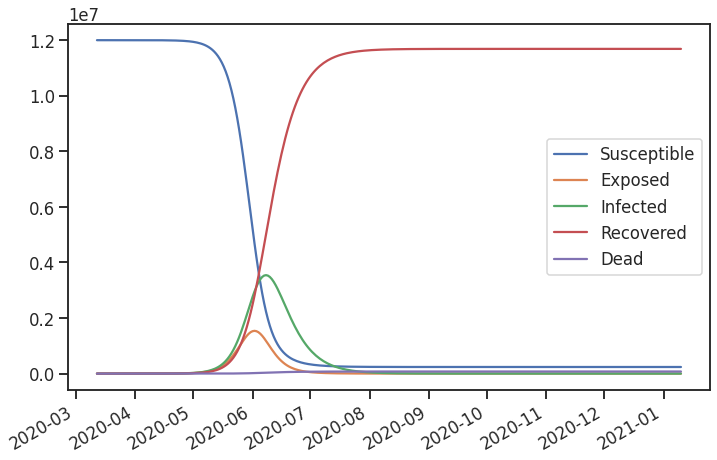

In [23]:
fig = plt.figure(figsize=(10,7))
plt.plot(train_subset.date, S, label='Susceptible')
plt.plot(train_subset.date, E, label='Exposed')
plt.plot(train_subset.date, I, label='Infected')
plt.plot(train_subset.date, R, label='Recovered')
plt.plot(train_subset.date, D, label='Dead')
plt.legend()
plt.tight_layout()
fig.autofmt_xdate()
plt.show()

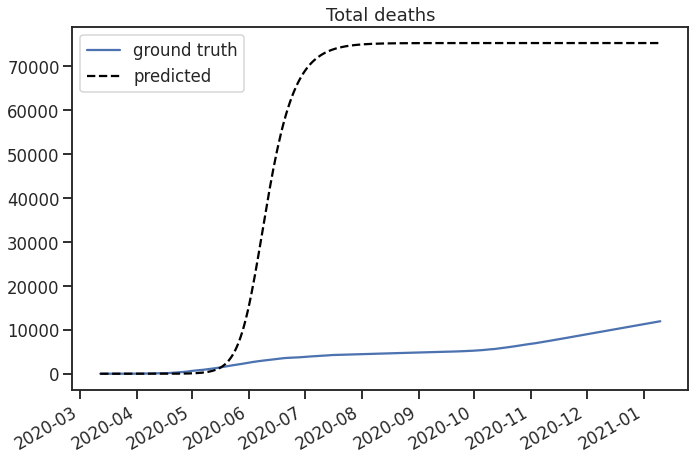

In [24]:
fig = plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='ground truth')
plt.plot(train_subset.date, D, label='predicted', color='black', linestyle='dashed' )
plt.legend()
plt.title('Total deaths')
plt.tight_layout()
fig.autofmt_xdate()
plt.show()

# Qaurantine measures

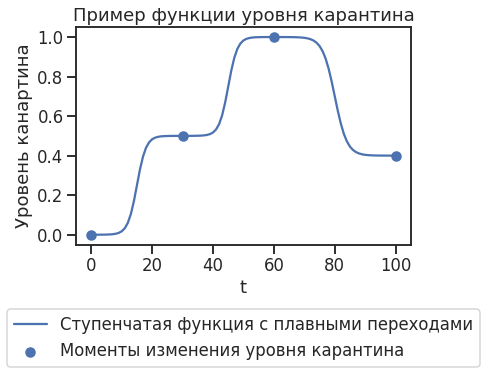

In [25]:
def sigmoid(x, xmin, xmax, a, b, c, r):
    x_scaled = (x - xmin) / (xmax - xmin)
    out = (a * np.exp(c * r) + b * np.exp(r * x_scaled)) / (np.exp(c * r) + np.exp(x_scaled * r))
    return out


def stepwise_soft(t, coefficients, r=20, c=0.5):
    t_arr = np.array(list(coefficients.keys()))

    min_index = np.min(t_arr)
    max_index = np.max(t_arr)

    if t <= min_index:
        return coefficients[min_index]
    elif t >= max_index:
        return coefficients[max_index]
    else:
        index = np.min(t_arr[t_arr >= t])

    if len(t_arr[t_arr < index]) == 0:
        return coefficients[index]
    prev_index = np.max(t_arr[t_arr < index])
    # sigmoid smoothing
    q0, q1 = coefficients[prev_index], coefficients[index]
    out = sigmoid(t, prev_index, index, q0, q1, c, r)
    return out

t_range = np.arange(100)
coefficients = {
    0: 0,
    30: 0.5,
    60: 1,
    100: 0.4,
}

plt.title('Пример функции уровня карантина')
plt.scatter(coefficients.keys(), coefficients.values(), label='Моменты изменения уровня карантина')
plt.plot(t_range, [stepwise_soft(t, coefficients, r=20, c=0.5) for t in t_range], label='Ступенчатая функция с плавными переходами')
plt.xlabel('t')
plt.ylabel('Уровень канартина')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6),)
plt.show()

# Train SEIRD + hidden/visible groups + quarantine

In [26]:
from sir_models.fitters import HiddenCurveFitter
from sir_models.models import SEIRHidden

In [27]:
stepwize_size = 60

weights = {
    'I': 0.25,
    'R': 0.25,
    'D': 0.5,
}
model = SEIRHidden(stepwise_size=stepwize_size)
fitter = HiddenCurveFitter(
     new_deaths_col='deaths_per_day_ma7',
     new_cases_col='infected_per_day_ma7',
     new_recoveries_col='recovered_per_day_ma7',
     
     weights=weights,
     max_iters=1000,
     save_params_every=50,
)
fitter.fit(model, train_subset)

In [28]:
result = fitter.result
result

In [29]:
train_initial_conditions = model.get_initial_conditions(train_subset)
train_t = np.arange(len(train_subset))

(S, E, I, Iv, R, Rv, D, Dv), history = model.predict(train_t, train_initial_conditions)
(new_exposed,
         new_infected_invisible, new_infected_visible,
         new_recovered_invisible,
         new_recovered_visible,
         new_dead_invisible, new_dead_visible) = model.compute_daily_values(S, E, I, Iv, R, Rv, D, Dv)

In [30]:
daily_df = pd.DataFrame(
    {
        'date': train_subset.date[1:].values,
        'new_exposed': new_exposed,
        'new_infected_invisible': new_infected_invisible,
        'new_infected_visible': new_infected_visible,
        'new_recovered_invisible': new_recovered_invisible,
        'new_recovered_visible': new_recovered_visible,
        'new_dead_invisible': new_dead_invisible,
        'new_dead_visible': new_dead_visible
    },
    index=train_subset.date[1:])

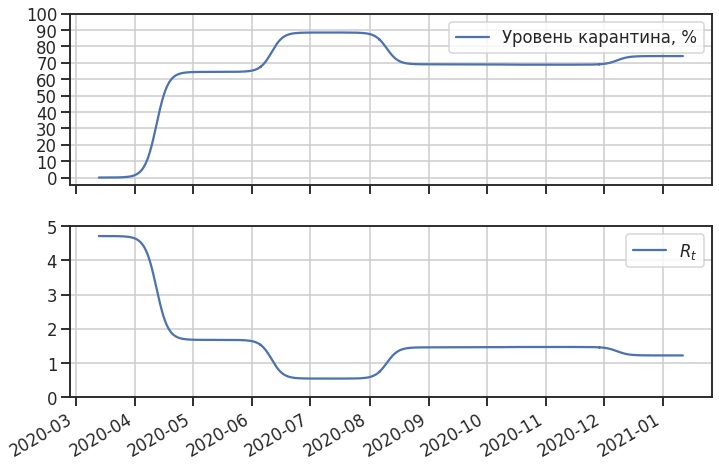

In [31]:
history_dates = df.date.iloc[0] + pd.to_timedelta(history.t, unit='days')

fig = plt.figure(figsize=(10, 7))
ax1 = plt.subplot(2,1,1)
plt.plot(history_dates, history.quarantine_mult, label='Уровень карантина, %')
plt.legend()
plt.tight_layout()
y_ticks = list(np.arange(0, 1.1, 0.1).round(1))
plt.gca().set_yticks(y_ticks)
plt.gca().set_yticklabels([f'{int(100*t)}' for t in y_ticks])
plt.grid()

plt.subplot(2,1,2, sharex=ax1)
plt.plot(history_dates, history.rt, label='$R_t$')
plt.ylim(0, 5)
plt.grid()
plt.legend()

fig.autofmt_xdate()
plt.show()

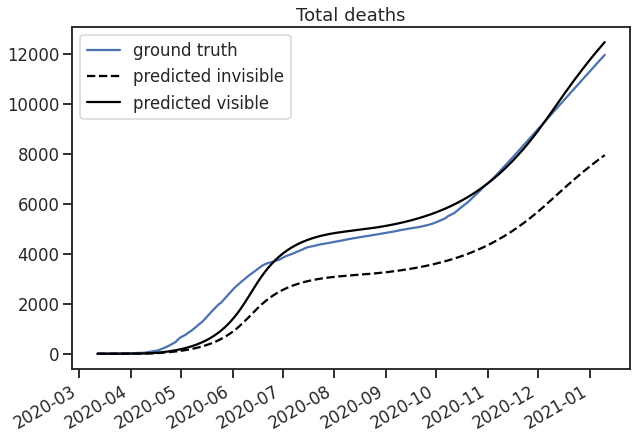

In [32]:
fig = plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='ground truth')
plt.plot(train_subset.date, D, label='predicted invisible', color='black', linestyle='dashed' )
plt.plot(train_subset.date, Dv, label='predicted visible', color='black')
plt.legend()
plt.title('Total deaths')
fig.autofmt_xdate()
plt.show()


# Evaluate model by cross-validation

In [ ]:
from sir_models.utils import eval_on_select_dates_and_k_days_ahead, smape

In [34]:
K = 30
last_day = df.date.iloc[-1] - pd.to_timedelta(K, unit='D')
eval_dates = pd.date_range(start='2020-06-01', end=last_day)[::20]
len(eval_dates)

14

In [35]:
def eval_hidden_moscow(train_df, t, train_t, eval_t):
    weights = {
        'I': 0.25,
        'R': 0.25,
        'D': 0.5,
    }
    model = SEIRHidden()
    fitter = HiddenCurveFitter(
        new_deaths_col='deaths_per_day_ma7',
        new_cases_col='infected_per_day_ma7',
        new_recoveries_col='recovered_per_day_ma7',
        weights=weights,
        max_iters=1000,
        save_params_every=500)
    fitter.fit(model, train_df)

    train_initial_conditions = model.get_initial_conditions(train_df)
    train_states, history = model.predict(train_t, train_initial_conditions, history=False)

    test_initial_conds = [compartment[-1] for compartment in train_states]
    test_states, history = model.predict(eval_t, test_initial_conds, history=False)
        
    return model, fitter, test_states

In [36]:
models, fitters, model_predictions, train_dfs, test_dfs = eval_on_select_dates_and_k_days_ahead(df,
                                                                                     eval_func=eval_hidden_moscow, 
                                                                                     eval_dates=eval_dates, 
                                                                                     k=K)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done   3 out of  14 | elapsed:  1.0min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:  1.2min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:  1.8min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   9 out of  14 | elapsed:  1.8min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:  1.8min remaining:   29.9s


KeyboardInterrupt: 

In [ ]:
x_dates = [tdf.date.iloc[-1] for tdf in test_dfs]

In [ ]:
model_pred_D = [pred[7] for pred in model_predictions]
true_D = [tdf.total_dead.values for tdf in test_dfs]
baseline_pred_D = [[tdf.iloc[-1].total_dead]*K for tdf in train_dfs]

In [ ]:
overall_errors_model = [mean_absolute_error(true, pred) for true, pred in zip(true_D, model_pred_D)]
overall_errors_baseline = [mean_absolute_error(true, pred) for true, pred in zip(true_D, baseline_pred_D)]
overall_smape_model = [smape(true, pred) for true, pred in zip(true_D, model_pred_D)]

In [ ]:
overall_errors_model

In [ ]:
print('MAE baseline', np.mean(overall_errors_baseline).round(3))
print('MAE model', np.mean(overall_errors_model).round(3))
print('SMAPE model', np.mean(overall_smape_model).round(3))

In [ ]:
ix = np.random.choice(np.arange(len(train_dfs[-5:])))

train_df = train_dfs[ix]
test_df = test_dfs[ix]
model_preds = model_predictions[ix]
baseline_predictions = baseline_pred_D[ix]
fitter = fitters[ix]
plt.figure(figsize=(10, 7))
plt.plot(train_df.date, train_df.total_dead, label='Train')
plt.plot(test_df.date, test_df.total_dead, label='Test')
plt.plot(test_df.date, model_preds[7], label='Predicted')
plt.plot(test_df.date, baseline_predictions, label='Baseline')
plt.legend()
plt.title(f'Total dead on date {test_df.date.iloc[0]}')
plt.show()

# Extend the model for two strains

In [39]:
date_of_first_strain2_contact = '2021-01-10'

In [40]:
from sir_models.models import SEIRHiddenTwoStrains

In [41]:
future_dates = pd.date_range(start=date_of_first_strain2_contact, periods=365)
future_t = np.max(train_t) + 1 + np.arange(len(future_dates))

assert len(future_dates) == len(future_t)

In [42]:
def make_two_strain_forecast(model, beta2_mult=1.5, new_strain_ratio=0.01, **kwargs):
    strain2_model = SEIRHiddenTwoStrains.from_strain_one_model(model)
    strain2_model.params['beta2_mult'].value = beta2_mult
    
    for key, value in kwargs.items():
        strain2_model.params[key].value = value
    

    E2_0 = E[-1] * new_strain_ratio
    E1_0 = E[-1] *  (1-new_strain_ratio)
    Iv2_0 = Iv[-1] * new_strain_ratio
    Iv1_0 = Iv[-1] *  (1-new_strain_ratio)
    I2_0 = I[-1] * new_strain_ratio
    I1_0 = I[-1] *  (1-new_strain_ratio)

    future_initial_conds_two_strain = (S[-1],
                                       E1_0,
                                       I1_0,
                                       Iv1_0,
                                       E2_0,
                                       I2_0,
                                       Iv2_0,
                                       R[-1],
                                       Rv[-1],
                                       D[-1],
                                       Dv[-1])
    
    print('new strain I, Iv', I2_0, Iv2_0)
    
    future_states, future_history = strain2_model.predict(future_t,
                                                 future_initial_conds_two_strain)
    future_daylies = strain2_model.compute_daily_values(*future_states)
    return strain2_model, future_states, future_history, future_daylies


In [43]:
strain2_model, future_states, future_history, future_daylies = make_two_strain_forecast(model)

(future_S, future_E1, future_I1, future_Iv1, future_E2, future_I2, future_Iv2, future_R, future_Rv, future_D,
     future_Dv) = future_states

(future_new_exposed_s1,
    future_new_infected_inv_s1,
    future_new_infected_vis_s1,
    future_new_recovered_inv_s1,
    future_new_recovered_vis_s1,
    future_new_dead_inv_s1,
    future_new_dead_vis_s1,
    future_new_exposed_s2,
    future_new_infected_inv_s2,
    future_new_infected_vis_s2,
    future_new_recovered_inv_s2,
    future_new_recovered_vis_s2,
    future_new_dead_inv_s2,
    future_new_dead_vis_s2) = future_daylies

new strain I, Iv 1338.6732696144934 405.80169177099873


In [45]:
future_daily_df = pd.DataFrame(
    {
        'date': future_dates[1:],
        't': future_t[1:],
        'new_exposed_s1': future_new_exposed_s1,
        'new_infected_inv_s1': future_new_infected_inv_s1,
        'new_infected_vis_s1': future_new_infected_vis_s1,
        'new_recovered_inv_s1': future_new_recovered_inv_s1,
        'new_recovered_vis_s1': future_new_recovered_vis_s1,
        'new_dead_inv_s1': future_new_dead_inv_s1,
        'new_dead_vis_s1': future_new_dead_vis_s1,
        'new_exposed_s2': future_new_exposed_s2,
        'new_infected_inv_s2': future_new_infected_inv_s2,
        'new_infected_vis_s2': future_new_infected_vis_s2,
        'new_recovered_inv_s2': future_new_recovered_inv_s2,
        'new_recovered_vis_s2': future_new_recovered_vis_s2,
        'new_dead_inv_s2': future_new_dead_inv_s2,
        'new_dead_vis_s2': future_new_dead_vis_s2
    },
    index=future_dates[1:])

new strain I, Iv 1338.6732696144934 405.80169177099873
new strain I, Iv 1338.6732696144934 405.80169177099873
new strain I, Iv 1338.6732696144934 405.80169177099873


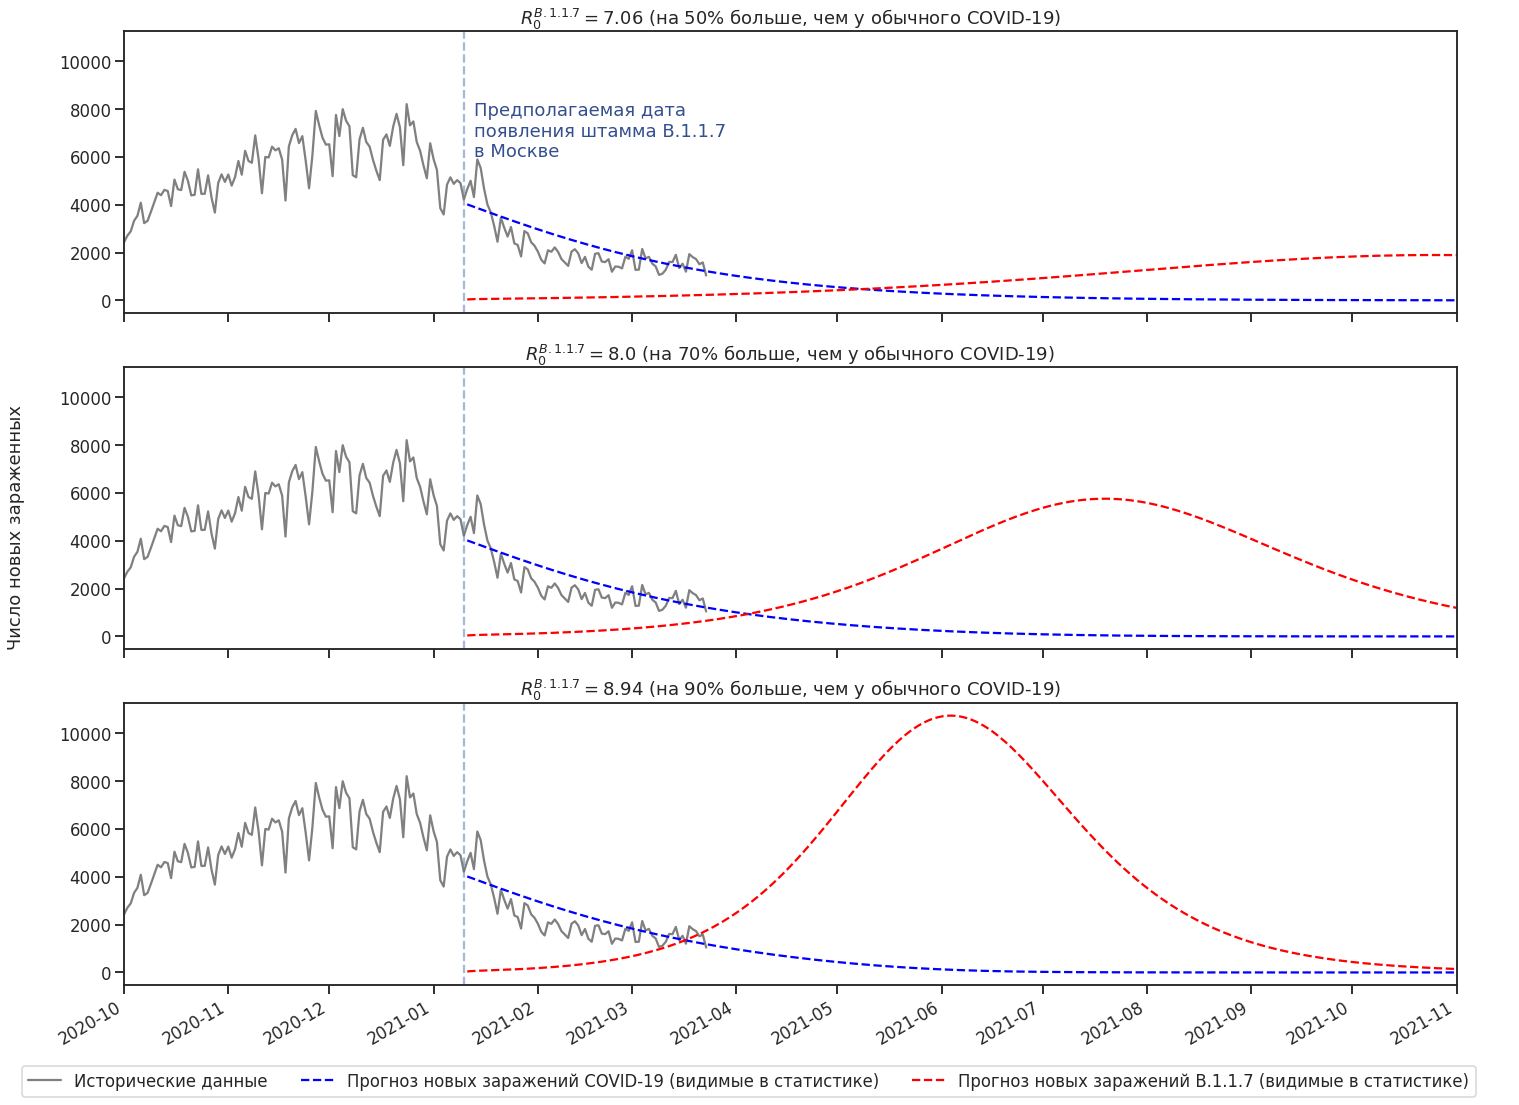

In [49]:
def make_scenario_plot(beta2_mult, new_strain_ratio):
    temp_model, temp_states, temp_history, temp_daylies = make_two_strain_forecast(model, beta2_mult=beta2_mult, new_strain_ratio=new_strain_ratio)

    (temp_S, temp_E1, temp_I1, temp_Iv1, temp_E2, temp_I2, temp_Iv2, temp_R, temp_Rv, temp_D,
         temp_Dv) = temp_states

    (temp_new_exposed_s1,
        temp_new_infected_inv_s1,
        temp_new_infected_vis_s1,
        temp_new_recovered_inv_s1,
        temp_new_recovered_vis_s1,
        temp_new_dead_inv_s1,
        temp_new_dead_vis_s1,
        temp_new_exposed_s2,
        temp_new_infected_inv_s2,
        temp_new_infected_vis_s2,
        temp_new_recovered_inv_s2,
        temp_new_recovered_vis_s2,
        temp_new_dead_inv_s2,
        temp_new_dead_vis_s2) = temp_daylies

    temp_daily_df = pd.DataFrame(
        {
            'date': future_dates[1:],
            't': future_t[1:],
            'new_exposed_s1': temp_new_exposed_s1,
            'new_infected_inv_s1': temp_new_infected_inv_s1,
            'new_infected_vis_s1': temp_new_infected_vis_s1,
            'new_recovered_inv_s1': temp_new_recovered_inv_s1,
            'new_recovered_vis_s1': temp_new_recovered_vis_s1,
            'new_dead_inv_s1': temp_new_dead_inv_s1,
            'new_dead_vis_s1': temp_new_dead_vis_s1,
            'new_exposed_s2': temp_new_exposed_s2,
            'new_infected_inv_s2': temp_new_infected_inv_s2,
            'new_infected_vis_s2': temp_new_infected_vis_s2,
            'new_recovered_inv_s2': temp_new_recovered_inv_s2,
            'new_recovered_vis_s2': temp_new_recovered_vis_s2,
            'new_dead_inv_s2': temp_new_dead_inv_s2,
            'new_dead_vis_s2': temp_new_dead_vis_s2
        },
        index=future_dates[1:])
    
    plt.plot(temp_daily_df.date, temp_daily_df.new_infected_vis_s1, label='Прогноз новых заражений COVID-19 (видимые в статистике)', linestyle='--', color='blue')
    plt.plot(temp_daily_df.date, temp_daily_df.new_infected_vis_s2,  label='Прогноз новых заражений B.1.1.7 (видимые в статистике)', linestyle='--', color='red')
    return temp_daily_df


fig = plt.figure(figsize=(20, 15))

ax1 = plt.subplot(3, 1, 1)
plt.title(f'$R_{{0}}^{{B.1.1.7}} = {round(model.params["r0"] * 1.5, 2)}$ (на 50% больше, чем у обычного COVID-19)')
plt.xlim(pd.to_datetime('2020-10-01'), pd.to_datetime('2021-11-01')) 
plt.setp(plt.gca().get_xticklabels(), visible=False)

x_line_annotation = pd.to_datetime(date_of_first_strain2_contact)
x_text_annotation = x_line_annotation + pd.to_timedelta(3, unit='D')
plt.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
plt.text(x=x_text_annotation, 
         y=6000, 
        s='Предполагаемая дата \nпоявления штамма B.1.1.7\nв Москве', 
         horizontalalignment='left',
        color='#334f8d',
        fontweight='medium')
plt.plot(df.date, df.infected_per_day, label='Исторические данные', color='gray')
make_scenario_plot(beta2_mult=1.5, new_strain_ratio=0.01)


plt.subplot(3, 1, 2, sharex=ax1, sharey=ax1)
plt.title(f'$R_{{0}}^{{B.1.1.7}} = {round(model.params["r0"] * 1.7, 2)}$ (на 70% больше, чем у обычного COVID-19)')
plt.setp(plt.gca().get_xticklabels(), visible=False)
plt.plot(df.date, df.infected_per_day, label='Исторические данные', color='gray')
plt.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
make_scenario_plot(beta2_mult=1.7, new_strain_ratio=0.01)


plt.subplot(3, 1, 3, sharex=ax1, sharey=ax1)
plt.title(f'$R_{{0}}^{{B.1.1.7}} = {round(model.params["r0"] * 1.9, 2)}$ (на 90% больше, чем у обычного COVID-19)')
plt.plot(df.date, df.infected_per_day, label='Исторические данные', color='gray')
plt.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
make_scenario_plot(beta2_mult=1.9, new_strain_ratio=0.01)


handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, 
           loc='lower center',  bbox_to_anchor=(0.52, 0), ncol=3, 
           fancybox=True)


fmt_month = mdates.MonthLocator(interval=1)
plt.gca().xaxis.set_major_locator(fmt_month)
fig.autofmt_xdate()

fig.text(-0.02, 0.5, 'Число новых зараженных', va='center', rotation='vertical')
fig.text(0.5, -0.02, ' ', va='center') # This hack extends canvas so that legend can fit in
plt.tight_layout()
plt.show()

new strain I, Iv 13.386732696144936 4.058016917709987
new strain I, Iv 133.86732696144935 40.580169177099876
new strain I, Iv 1338.6732696144934 405.80169177099873


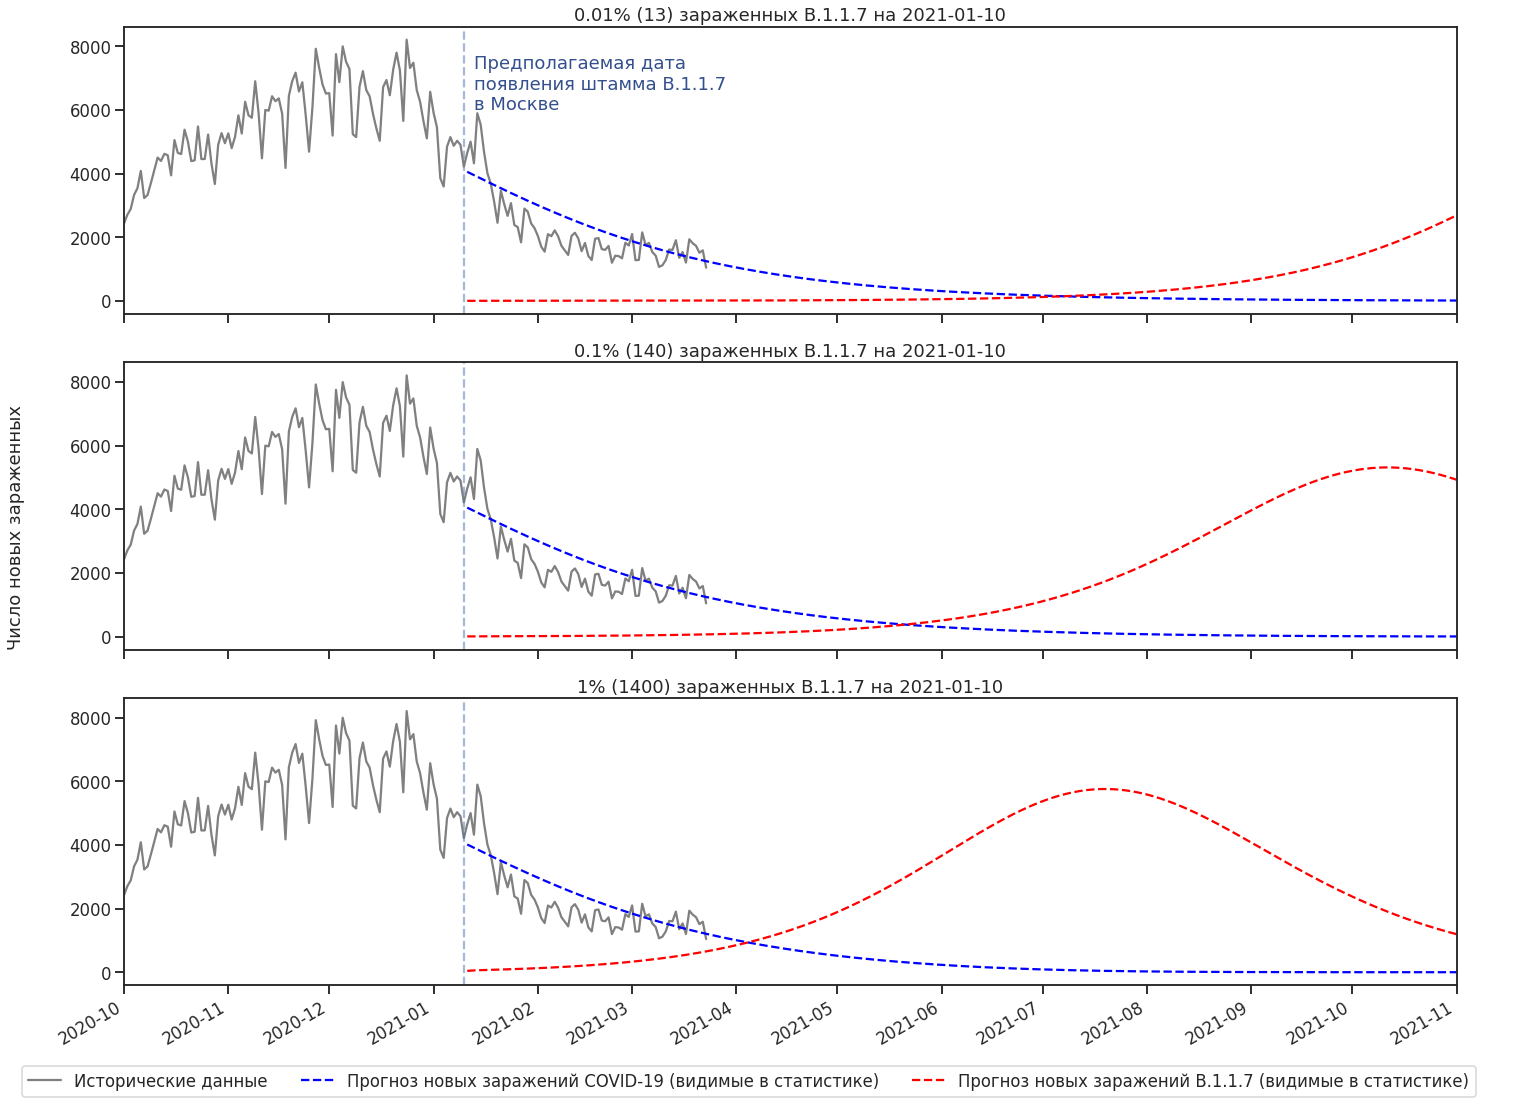

In [50]:
def get_scenario_df(beta2_mult, new_strain_ratio, **kwargs):
    temp_model, temp_states, temp_history, temp_daylies = make_two_strain_forecast(model, beta2_mult=beta2_mult, new_strain_ratio=new_strain_ratio, **kwargs)

    (temp_S, temp_E1, temp_I1, temp_Iv1, temp_E2, temp_I2, temp_Iv2, temp_R, temp_Rv, temp_D,
         temp_Dv) = temp_states

    (temp_new_exposed_s1,
        temp_new_infected_inv_s1,
        temp_new_infected_vis_s1,
        temp_new_recovered_inv_s1,
        temp_new_recovered_vis_s1,
        temp_new_dead_inv_s1,
        temp_new_dead_vis_s1,
        temp_new_exposed_s2,
        temp_new_infected_inv_s2,
        temp_new_infected_vis_s2,
        temp_new_recovered_inv_s2,
        temp_new_recovered_vis_s2,
        temp_new_dead_inv_s2,
        temp_new_dead_vis_s2) = temp_daylies

    temp_daily_df = pd.DataFrame(
        {
            'date': future_dates[1:],
            't': future_t[1:],
            'new_exposed_s1': temp_new_exposed_s1,
            'new_infected_inv_s1': temp_new_infected_inv_s1,
            'new_infected_vis_s1': temp_new_infected_vis_s1,
            'new_recovered_inv_s1': temp_new_recovered_inv_s1,
            'new_recovered_vis_s1': temp_new_recovered_vis_s1,
            'new_dead_inv_s1': temp_new_dead_inv_s1,
            'new_dead_vis_s1': temp_new_dead_vis_s1,
            'new_exposed_s2': temp_new_exposed_s2,
            'new_infected_inv_s2': temp_new_infected_inv_s2,
            'new_infected_vis_s2': temp_new_infected_vis_s2,
            'new_recovered_inv_s2': temp_new_recovered_inv_s2,
            'new_recovered_vis_s2': temp_new_recovered_vis_s2,
            'new_dead_inv_s2': temp_new_dead_inv_s2,
            'new_dead_vis_s2': temp_new_dead_vis_s2
        },
        index=future_dates[1:])
    return temp_daily_df

def make_scenario_plot(beta2_mult, new_strain_ratio, **kwargs):
    temp_daily_df = get_scenario_df(beta2_mult, new_strain_ratio, **kwargs)
    
    plt.plot(temp_daily_df.date, temp_daily_df.new_infected_vis_s1, label='Прогноз новых заражений COVID-19 (видимые в статистике)', linestyle='--', color='blue')
    plt.plot(temp_daily_df.date, temp_daily_df.new_infected_vis_s2,  label='Прогноз новых заражений B.1.1.7 (видимые в статистике)', linestyle='--', color='red')
    return temp_daily_df


fig = plt.figure(figsize=(20, 15))

ax1 = plt.subplot(3, 1, 1)
plt.title('0.01% (13) зараженных B.1.1.7 на 2021-01-10')
plt.xlim(pd.to_datetime('2020-10-01'), pd.to_datetime('2021-11-01'))
plt.setp(plt.gca().get_xticklabels(), visible=False)

x_line_annotation = pd.to_datetime(date_of_first_strain2_contact)
x_text_annotation = x_line_annotation + pd.to_timedelta(3, unit='D')
plt.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
plt.text(x=x_text_annotation, 
         y=6000, 
        s='Предполагаемая дата \nпоявления штамма B.1.1.7\nв Москве', 
         horizontalalignment='left',
        color='#334f8d',
        fontweight='medium')
plt.plot(df.date, df.infected_per_day, label='Исторические данные', color='gray')
make_scenario_plot(beta2_mult=1.7, new_strain_ratio=0.0001)


plt.subplot(3, 1, 2, sharex=ax1, sharey=ax1)
plt.title('0.1% (140) зараженных B.1.1.7 на 2021-01-10')
plt.setp(plt.gca().get_xticklabels(), visible=False)
plt.plot(df.date, df.infected_per_day, label='Исторические данные', color='gray')
plt.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
make_scenario_plot(beta2_mult=1.7, new_strain_ratio=0.001)


plt.subplot(3, 1, 3, sharex=ax1, sharey=ax1)
plt.title('1% (1400) зараженных B.1.1.7 на 2021-01-10')
plt.plot(df.date, df.infected_per_day, label='Исторические данные', color='gray')
plt.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
make_scenario_plot(beta2_mult=1.7, new_strain_ratio=0.01)


fmt_month = mdates.MonthLocator(interval=1)
plt.gca().xaxis.set_major_locator(fmt_month)
fig.autofmt_xdate()

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, 
           loc='lower center',  bbox_to_anchor=(0.52, 0), ncol=3, 
           fancybox=True)

fig.text(-0.02, 0.5, 'Число новых зараженных', va='center', rotation='vertical')
fig.text(0.5, -0.02, ' ', va='center') # This hack extends canvas so that legend can fit in
plt.tight_layout()
plt.show()

In [55]:
model.params.add('t360_q', value=model.params['t300_q'].value)

new strain I, Iv 1338.6732696144934 405.80169177099873
new strain I, Iv 1338.6732696144934 405.80169177099873
new strain I, Iv 1338.6732696144934 405.80169177099873


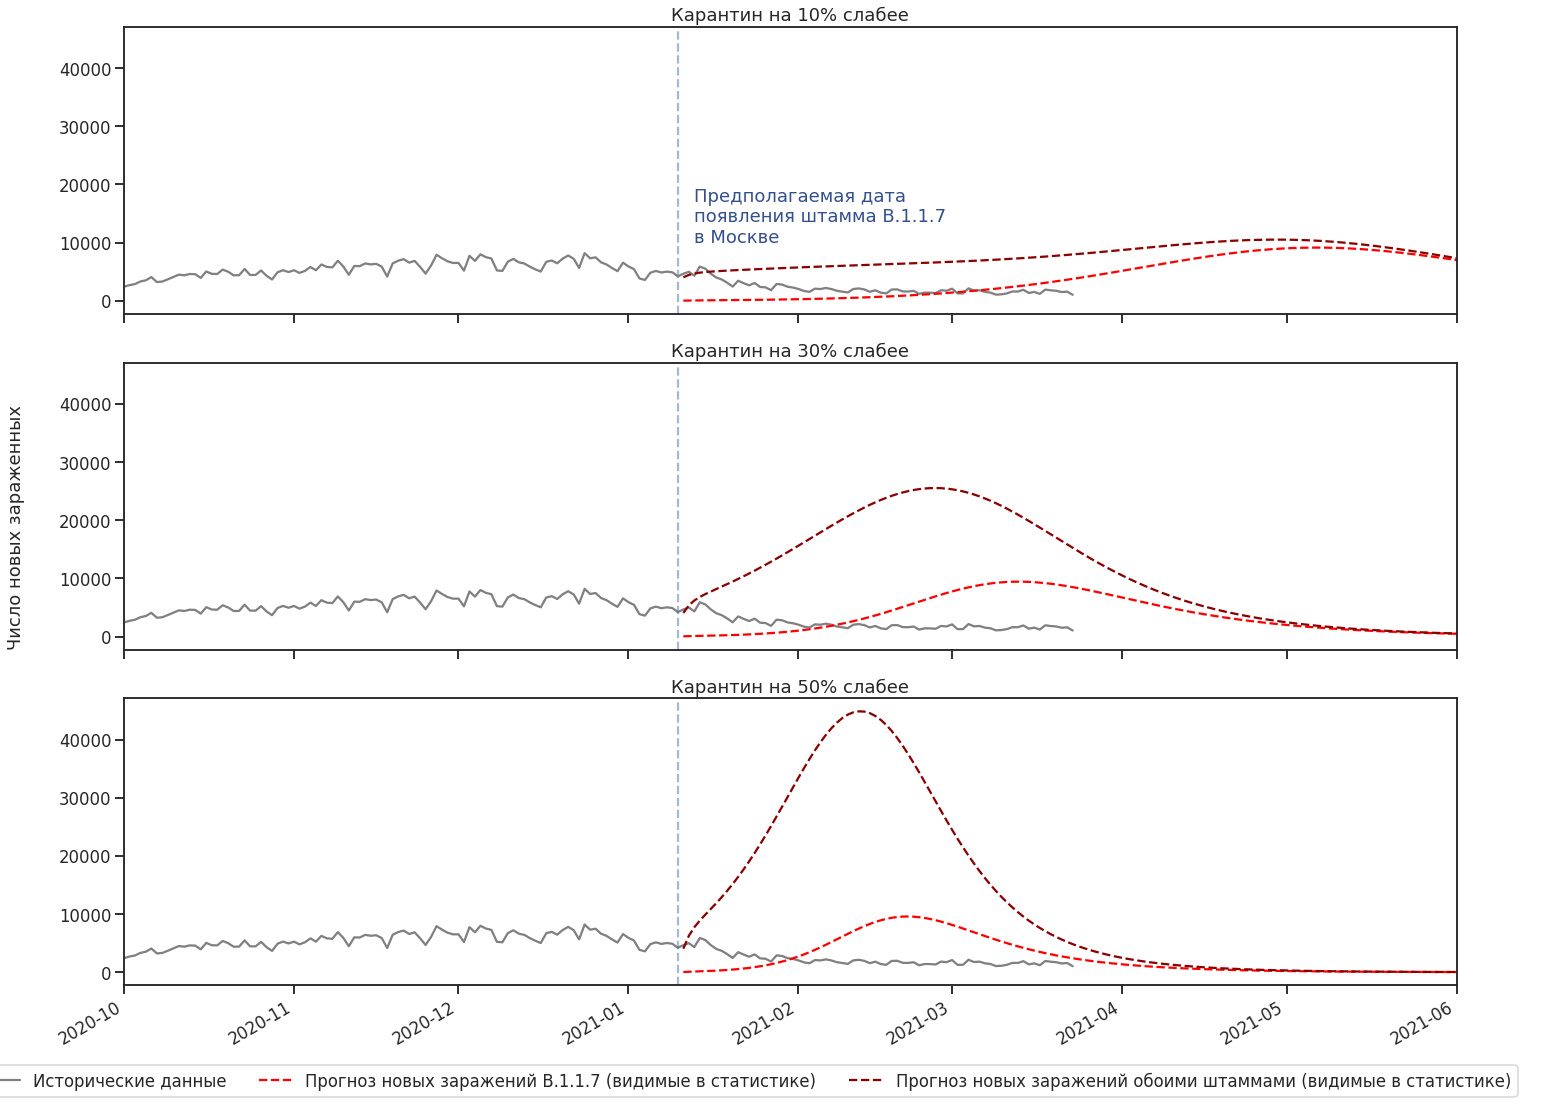

In [54]:
def make_quarantine_scenario_plot(beta2_mult, new_strain_ratio, **kwargs):
    daily_df = get_scenario_df(beta2_mult, new_strain_ratio, **kwargs)
    plt.plot(daily_df.date, daily_df.new_infected_vis_s2,  
             label='Прогноз новых заражений B.1.1.7 (видимые в статистике)', linestyle='--', color='red')
    plt.plot(daily_df.date, 
             daily_df.new_infected_vis_s1+daily_df.new_infected_vis_s2,
             label='Прогноз новых заражений обоими штаммами (видимые в статистике)', linestyle='--', color='darkred')
    
fig = plt.figure(figsize=(20, 15))

ax1 = plt.subplot(3, 1, 1)
plt.title('Карантин на 10% слабее')
plt.xlim(pd.to_datetime('2020-10-01'), pd.to_datetime('2021-06-01'))
plt.setp(plt.gca().get_xticklabels(), visible=False)

x_line_annotation = pd.to_datetime(date_of_first_strain2_contact)
x_text_annotation = x_line_annotation + pd.to_timedelta(3, unit='D')
plt.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
plt.text(x=x_text_annotation, 
         y=10000, 
        s='Предполагаемая дата \nпоявления штамма B.1.1.7\nв Москве', 
         horizontalalignment='left',
        color='#334f8d',
        fontweight='medium')
plt.plot(df.date, df.infected_per_day, label='Исторические данные', color='gray')
make_quarantine_scenario_plot(beta2_mult=1.7, new_strain_ratio=0.01, t360_q=model.params['t360_q'].value - model.params['t360_q'].value*0.1)


plt.subplot(3, 1, 2, sharex=ax1, sharey=ax1)
plt.title('Карантин на 30% слабее')
plt.setp(plt.gca().get_xticklabels(), visible=False)
plt.plot(df.date, df.infected_per_day, label='Исторические данные', color='gray')
plt.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
make_quarantine_scenario_plot(beta2_mult=1.7, new_strain_ratio=0.01, t360_q=model.params['t360_q'].value - model.params['t360_q'].value*0.3)


plt.subplot(3, 1, 3, sharex=ax1, sharey=ax1)
plt.title('Карантин на 50% слабее')
plt.plot(df.date, df.infected_per_day, label='Исторические данные', color='gray')
plt.axvline(x=x_line_annotation, linestyle='dashed', alpha=0.5)
make_quarantine_scenario_plot(beta2_mult=1.7, new_strain_ratio=0.01, t360_q=model.params['t360_q'].value - model.params['t360_q'].value*0.5)

fmt_month = mdates.MonthLocator(interval=1)
plt.gca().xaxis.set_major_locator(fmt_month)
fig.autofmt_xdate()


handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, 
           loc='lower center',  bbox_to_anchor=(0.52, 0), ncol=3, 
           fancybox=True)

fig.text(-0.02, 0.5, 'Число новых зараженных', va='center', rotation='vertical')
fig.text(0.5, -0.02, ' ', va='center') # This hack extends canvas so that legend can fit in
plt.tight_layout()
plt.show()